In [4]:
import pickle

In [5]:
with open('cond_dists.pkl', 'rb') as inp:
    cond_dists = pickle.load(inp)

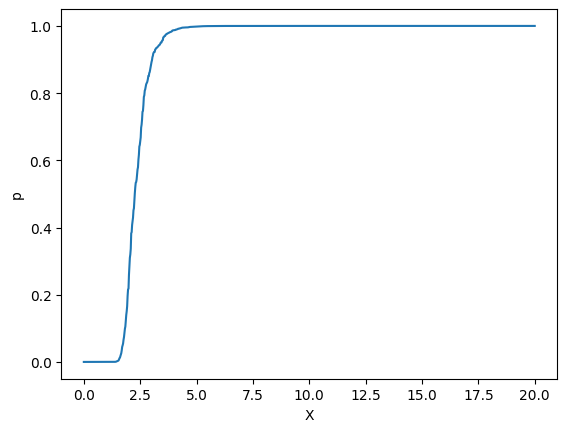

In [10]:
cond_dists[190].plot_distribution(log=False)

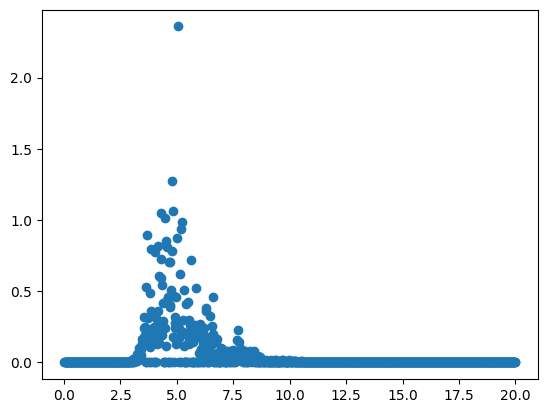

In [7]:
cond_dists[199].plot_density()